# Bellman Equation

Modern optimal control theory is heavily reliant on the [Bellman equation](http://en.wikipedia.org/wiki/Bellman_equation). This equation can be derived from the Bellman's prinicple of optimality:

>Principle of Optimality: An optimal policy has the property that whatever the initial state and initial decision are, the remaining decisions must constitute an optimal policy with regard to the state resulting from the first decision.

Let $F(x,a)$ be the cost of taking action $a$ at state $x$. Then the total cost can be expressed as:

$$V(x_0) = \min_{\{a_k\}_{k=0}^N} \sum_{k=0}^N F(x_k, a_k)$$

Now we can separate the first step from the remaining steps. This is equivalent to Bellman's principle of optimality.

$$ V(x_0) = \min_{a_0} \left( F(x_0, a_0) + \min_{\{a_k\}_{k=1}^N}  \sum_{k=1}^N  F(x_k, a_k) \right)$$

We now note that this is a recursive equation.

$$ V(x_0) = \min_{a_0} \left( F(x_0, a_0) + V(x_1) \right)$$

This equation can be solved using dynamic programming.

1. Start at the desired end point.
1. Perform all possible actions at the end point, recording their cost.
1. For the resulting states of the performed actions, again perform all actions.
1. If a state can be reached by more than one sequence of actions, choose the action sequence with the lower cost.
1. Repeat the process until the initial state is reached by an action sequence whose cost is lower than any other action sequences that may reach the initial state.

## Dynamic Programming Example

In [1]:
%pylab inline
from mpl_toolkits.mplot3d import Axes3D

rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 12

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Let us solve the problem of computing the shortest path across hilly terrain. We will represent the terrain using a sum of gaussians.

In [2]:
# sum of gaussian terrain model
def terrain(x):   
    peaks = [# center, height, sigma
             ((0.3,0.4), 2, 0.1),
             ((1.0,0.0), 1, 0.1),
             ((0.5,0.5), 1, 0.1),
             ((0.0,1.0), 1, 0.1),
             ((0.6,1.0), 2, 0.1),
             ((0.6,0.8), 2, 0.1),
             ((0.8,0.4), 2, 0.1),
             ((0.8,0.8), 2, 0.1),
             ((0.9,0.4), 1, 0.1),
             ((0.4,0.6), 1, 0.1),
             ((0.6,0.4), 1, 0.1),
             ((1.0,0.4), 1, 0.1),
             ((0.4,0.2), 3, 0.1),
             ((0.0,1.0), 1, 0.1),
             ]
    t = 0
    x = array(x)
    for peak in peaks:
        xp = peak[0]
        h = peak[1]
        sig = peak[2]
        d = array(x) - array(xp)
        t += h*exp(-d.dot(d)/sig**2)
    return t             

In [3]:
n = 30
x = linspace(0,1,n)
y = linspace(0,1,n)
nx = len(x)
ny = len(y)
 
z = zeros([nx,ny])
for i in range(nx):
    for j in range(ny):
        z[j,i] = terrain([x[i], y[j]])
X,Y = meshgrid(x, y)

def position(i_x):
    return array([x[i_x[0]], y[i_x[1]]])

i_x0 = (int(0.3*n),int(0.3*n))
i_xf = (int(0.7*n),int(0.9*n))
x0 = position(i_x0)
xf = position(i_xf)

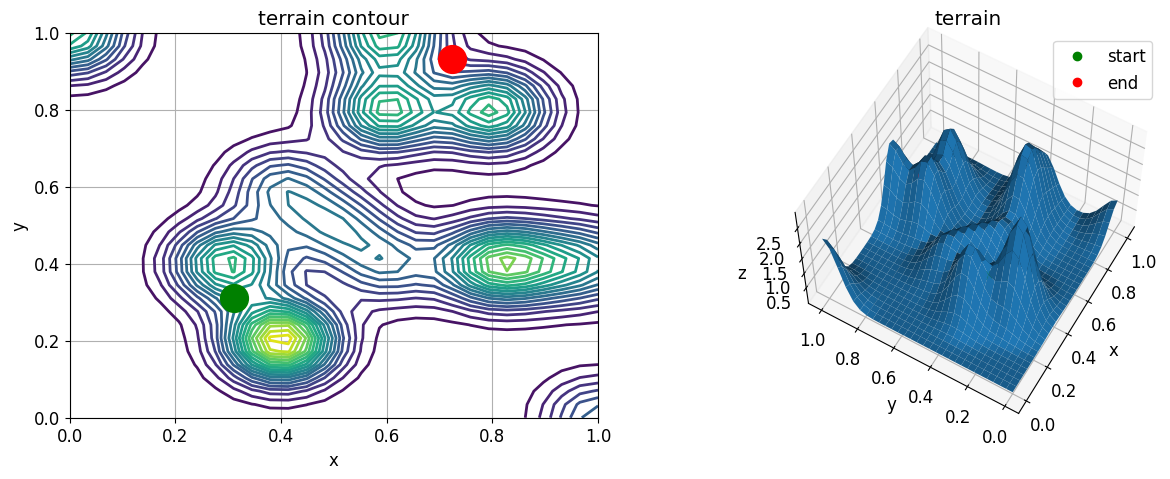

In [4]:
figure(figsize(15,5))
subplot(121)
contour(X, Y, z, 20)
xlabel('x')
ylabel('y')
title('terrain contour')
plot(x0[0], x0[1], 'go', markersize=20)
plot(xf[0], xf[1], 'ro', markersize=20)
grid()

ax = subplot(122, projection='3d')
h_terrain = ax.plot_surface(X, Y, z, cstride=1, rstride=1)
h_start = ax.plot3D([x0[0]], [x0[1]], [terrain(x0)], 'go')[0]
h_end = ax.plot3D([xf[0]], [xf[1]], [terrain(xf)], 'ro')[0]
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
title('terrain')
ax.view_init(elev=60, azim=-150)
ax.legend(handles=[h_start, h_end], labels=['start','end'])

For two adjacent cells, the path length can be approximated using the distance between the cell centers.

In [5]:
def cost(x0, x1):
    # estimated path length
    s = sqrt((x0[0] - x1[0])**2 +  (x0[1] - x1[1])**2 + (terrain(x0) - terrain(x1))**2)
    return s 

In [6]:
# initialize at the final point
i_x_prev = i_xf
i_x = i_x_prev
V = zeros((n,n))
live = [i_x]
import copy

# bound all points to within the defined terrain
def in_bounds(i_x):
    return (i_x[0]>=0 and i_x[0]<n and i_x[1]>=0 and i_x[1]<n)
    
# define all possible actions
possible_actions = [
    (1, 0), (-1, 0), #left/right
    (0, 1), (0, -1), #up/down
    (1, 1), (1, -1), (-1, -1), (-1, 1) #NE, SE, SW, NW
]

# process all remaining moves (live nodes)
V_data = []
while len(live) > 0:
    new = set()
    for p in live:
        for a in possible_actions:
            pa = (p[0] - a[0], p[1] - a[1]) # move backwards so action negative
            if in_bounds(pa):
                V_new = cost(position(p), position(pa)) + V[p[0], p[1]]
                V_old = V[pa[0], pa[1]]
                if V_old == 0 or V_new < V_old:
                    V[pa[0], pa[1]] = V_new
                    new.add(pa)
    live = new
    V_data.append(copy.copy(V))

In [7]:
# find optimal path, start at initial conditions and choose lowest cost moving
# forward using Bellman's principle of optimality
p = i_x0
p_hist_opt = [p]
count = 0
while p != i_xf:
    count += 1
    pa_opt = None
    V_old = V[p[0], p[1]]
    for a in possible_actions:
        pa = (p[0] + a[0], p[1] + a[1])
        if in_bounds(pa):
            V_new = V[pa[0], pa[1]]
            if pa_opt is None or pa==i_xf or (V_new < V_opt and V_new < V_old):
                V_opt = V_new
                pa_opt = pa
        if pa == i_xf: break
    if count > 1000: break
    p = pa_opt
    p_hist_opt.append(p)
pos_hist_opt = array([position(p) for p in p_hist_opt])

In [16]:
import matplotlib.animation

# video animation
from tempfile import NamedTemporaryFile
from IPython.display import HTML

def anim_dyn_prog(V_data):
    nV = len(V_data)
    nP = len(pos_hist_opt)
    fig = figure(figsize(8,4.5))
    ax = subplot(111)
    ax.pcolor(X, Y, V_data[0].T, vmin=V_data[-1].min(), vmax=V_data[-1].max())
    plot([x0[0]], [x0[1]], 'go')
    plot([xf[0]], [xf[1]], 'ro')
    xlabel('x')
    ylabel('y')
    title('dynamic programming cost to go for each state')
    def update(i):
        if i < nV:
            ax.pcolor(X, Y, V_data[i].T, vmin=V_data[-1].min(), vmax=V_data[-1].max())
        else:
            j = i - nV + 1
            ax.plot(pos_hist_opt[:j,0], pos_hist_opt[:j,1] , '-k', linewidth=5)
    return matplotlib.animation.FuncAnimation(fig, update, frames=nV + nP, interval=100)


In [17]:
anim = anim_dyn_prog(V_data)

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close();

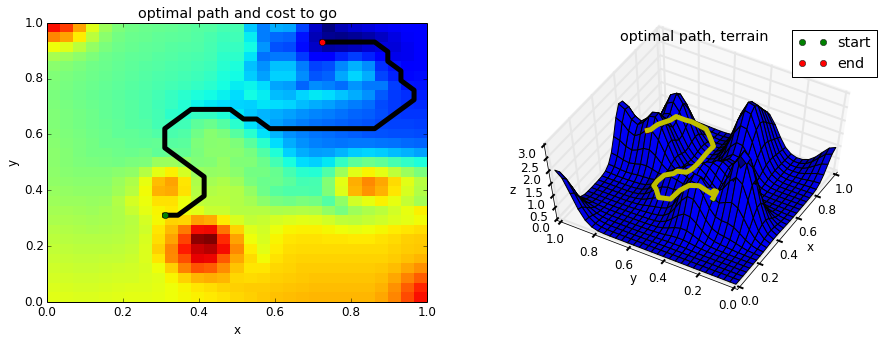

In [10]:
figure(figsize=(15,5))
subplot(121)
pcolor(X, Y, V.T)
plot(pos_hist_opt[:,0], pos_hist_opt[:,1] , '-k', linewidth=5)
plot([x0[0]], [x0[1]], 'go')
plot([xf[0]], [xf[1]], 'ro')
xlabel('x')
ylabel('y')
title('optimal path and cost to go')

ax = subplot(122, projection='3d')
h_terrain = ax.plot_surface(X, Y, z, cstride=1, rstride=1)
h_start = ax.plot3D([x0[0]], [x0[1]], [terrain(x0)], 'go')
h_end = ax.plot3D([xf[0]], [xf[1]], [terrain(xf)], 'ro')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
title('optimal path, terrain')
ax.view_init(elev=60, azim=-150)
ax.legend( ['start','end','terrain'])
terrain_opt = [terrain(pos_hist_opt[i,:]) for i in range(len(pos_hist_opt[:,0]))]
ax.plot3D(pos_hist_opt[:,0], pos_hist_opt[:,1], terrain_opt, '-y', linewidth=5)